# LTV Analysis - Exploratory data analysis
Author: Ricardo Raspini Motta

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import calibration_curve 
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
import lifelines

from sklearn.model_selection import GridSearchCV

In [2]:
base = catalog.load("base")
xs = catalog.load("xs")

[11/26/23 11:23:29] INFO     Loading data from 'base' (CSVDataSet)...                           ]8;id=92966;file:///home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=576850;file:///home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'xs' (CSVDataSet)...                             ]8;id=239904;file:///home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=195426;file:///home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [3]:
base

,user_id,customer_started_at,customer_churned_at,product,commission,channel,age_bucket,operating_system
0,37d76d441d,2020-12-01,NaN,product_a,12.1775,channel_a,55+,iOS
1,cdc1327d79,2022-05-09,NaN,product_a,12.4575,channel_a,18-24,iOS
2,fac8c03aa8,2021-11-20,2023-01-01,product_c,21.6625,channel_a,35-39,Android
3,b0c703a998,2020-05-21,NaN,product_a,12.0475,channel_b,35-39,Android
4,0276bcc756,2021-04-15,NaN,product_c,15.7700,channel_b,35-39,Android
...,...,...,...,...,...,...,...,...
102618,7df1a34a0d,2021-02-12,NaN,product_a,12.6825,channel_a,45-49,iOS
102619,58ce7b5a49,2022-11-27,NaN,product_b,13.6975,channel_a,45-49,iOS
102620,4744036910,2022-07-22,NaN,product_a,12.1925,channel_a,45-49,iOS
102621,ca58e4734d,2021-07-16,NaN,product_a,13.7525,channel_a,50-54,Android


In [4]:
base["age_bucket"].value_counts()


age_bucket
30-34        22731
25-29        22346
35-39        14100
55+          11560
18-24        10458
40-44         9266
45-49         6298
50-54         5810
undefined       54
Name: count, dtype: int64

In [5]:
base["operating_system"].value_counts()


operating_system
Android      48405
iOS          47520
iPadOS         797
iPhone OS       18
Name: count, dtype: int64

In [6]:
base.loc[:, "operating_system"] = base["operating_system"].replace({"iPadOS": "iOS", "iPhone OS": "iOS"})

In [7]:
xs

,user_id,product,commission,date
0,ccc05d82e1,product_y,499.6000,2022-08-05
1,77a488f223,product_y,821.2950,2022-10-20
2,e717cb5a0b,product_y,1215.0350,2023-01-19
3,1e9ca78b5b,product_y,413.1800,2022-12-20
4,eee1f85c5c,product_y,354.4475,2022-10-06
...,...,...,...,...
1313,b46d770837,product_y,579.6650,2022-11-01
1314,af3b28aac0,product_y,418.3700,2022-10-11
1315,623b0fe810,product_x,1269.0025,2022-06-30
1316,3cc2642221,product_y,377.0550,2022-09-22


In [8]:
len(base["user_id"].unique()) == len(base)

True

In [9]:
len(xs["user_id"].unique()) == len(xs)

False

In [10]:
xs["user_id"].value_counts().head(1)


user_id
995528dadd    5
Name: count, dtype: int64

In [11]:
base.loc[base["user_id"]=="995528dadd"]

,user_id,customer_started_at,customer_churned_at,product,commission,channel,age_bucket,operating_system
22280,995528dadd,2022-04-24,NaN,product_a,12.925,channel_b,30-34,Android


In [12]:
xs.loc[xs["user_id"]=="995528dadd"]

,user_id,product,commission,date
163,995528dadd,product_y,262.00,2022-12-30
164,995528dadd,product_y,1723.60,2022-05-05
165,995528dadd,product_y,195.46,2022-05-05
166,995528dadd,product_y,262.00,2022-12-30
167,995528dadd,product_y,244.60,2023-02-08


In [13]:
def get_commission_per_product(df):
    comission_per_product = df.groupby("product").agg({"commission": ["sum","count"]})
    comission_per_product.columns = list(map('_'.join, comission_per_product.columns.values))
    
    comission_per_product.loc[:,"commission_per_unit"] = comission_per_product["commission_sum"] / comission_per_product["commission_count"]
    return comission_per_product

In [14]:
comission_per_product_base = get_commission_per_product(base)
comission_per_product_xs = get_commission_per_product(xs)
comission_per_product = pd.concat([
        comission_per_product_base,
        comission_per_product_xs
    ],
     ignore_index=False).reset_index()

In [15]:
comission_per_product

,product,commission_sum,commission_count,commission_per_unit
0,product_a,1.014396e+06,82084,12.358022
1,product_b,6.470865e+04,4618,14.012268
2,product_c,3.063894e+05,15921,19.244357
3,product_x,7.797592e+04,79,987.036930
4,product_y,6.511947e+05,976,667.207677


In [16]:
xs = pd.merge(
    xs,
    pd.get_dummies(xs["product"]),
    left_index=True,
    right_index=True,
)

grouped_xs = xs.groupby("user_id").sum()[["commission", "product_x", "product_y"]].reset_index()

df = pd.merge(
    base,
    grouped_xs,
    on="user_id",
    how="left",
    suffixes=["_base", "_xs"]
)

datetime_cols = ["customer_churned_at", "customer_started_at"]
for col in datetime_cols:
    df.loc[:, col] = pd.to_datetime(df[col], errors="coerce", utc=False)

df.loc[:,"is_churn"] = ~df["customer_churned_at"].isna()

In [17]:
df[["product_x", "product_x"]]

,product_x,product_x
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
102618,NaN,NaN
102619,NaN,NaN
102620,NaN,NaN
102621,NaN,NaN


In [18]:
df.loc[:,"is_xs"] = np.where(df[["product_x", "product_x"]].fillna(0).sum(axis=1) >0, 1, 0)

In [19]:
df.groupby("product").agg({"is_churn": "mean"})

,is_churn
product,
product_a,0.363749
product_b,0.295366
product_c,0.460775


In [20]:
df.groupby("channel").agg({"is_churn": "mean"})

,is_churn
channel,
channel_a,0.405983
channel_b,0.350590


In [21]:
df.groupby("operating_system").agg({"is_churn": "mean"})

,is_churn
operating_system,
Android,0.406115
iOS,0.316624


In [22]:
df

,user_id,customer_started_at,customer_churned_at,product,commission_base,channel,age_bucket,operating_system,commission_xs,product_x,product_y,is_churn,is_xs
0,37d76d441d,2020-12-01 00:00:00,NaT,product_a,12.1775,channel_a,55+,iOS,NaN,NaN,NaN,False,0
1,cdc1327d79,2022-05-09 00:00:00,NaT,product_a,12.4575,channel_a,18-24,iOS,NaN,NaN,NaN,False,0
2,fac8c03aa8,2021-11-20 00:00:00,2023-01-01 00:00:00,product_c,21.6625,channel_a,35-39,Android,NaN,NaN,NaN,True,0
3,b0c703a998,2020-05-21 00:00:00,NaT,product_a,12.0475,channel_b,35-39,Android,NaN,NaN,NaN,False,0
4,0276bcc756,2021-04-15 00:00:00,NaT,product_c,15.7700,channel_b,35-39,Android,NaN,NaN,NaN,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102618,7df1a34a0d,2021-02-12 00:00:00,NaT,product_a,12.6825,channel_a,45-49,iOS,NaN,NaN,NaN,False,0
102619,58ce7b5a49,2022-11-27 00:00:00,NaT,product_b,13.6975,channel_a,45-49,iOS,NaN,NaN,NaN,False,0
102620,4744036910,2022-07-22 00:00:00,NaT,product_a,12.1925,channel_a,45-49,iOS,NaN,NaN,NaN,False,0
102621,ca58e4734d,2021-07-16 00:00:00,NaT,product_a,13.7525,channel_a,50-54,Android,NaN,NaN,NaN,False,0


In [23]:
df.groupby("age_bucket").agg({"is_churn": "mean"})

,is_churn
age_bucket,
18-24,0.375311
25-29,0.343820
30-34,0.368132
35-39,0.413617
40-44,0.432981
45-49,0.410924
50-54,0.356282
55+,0.349221
undefined,0.796296


In [24]:
df.groupby("is_xs").agg({"is_churn": "mean"})

,is_churn
is_xs,
0,0.376038
1,0.041667


In [25]:
df

,user_id,customer_started_at,customer_churned_at,product,commission_base,channel,age_bucket,operating_system,commission_xs,product_x,product_y,is_churn,is_xs
0,37d76d441d,2020-12-01 00:00:00,NaT,product_a,12.1775,channel_a,55+,iOS,NaN,NaN,NaN,False,0
1,cdc1327d79,2022-05-09 00:00:00,NaT,product_a,12.4575,channel_a,18-24,iOS,NaN,NaN,NaN,False,0
2,fac8c03aa8,2021-11-20 00:00:00,2023-01-01 00:00:00,product_c,21.6625,channel_a,35-39,Android,NaN,NaN,NaN,True,0
3,b0c703a998,2020-05-21 00:00:00,NaT,product_a,12.0475,channel_b,35-39,Android,NaN,NaN,NaN,False,0
4,0276bcc756,2021-04-15 00:00:00,NaT,product_c,15.7700,channel_b,35-39,Android,NaN,NaN,NaN,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102618,7df1a34a0d,2021-02-12 00:00:00,NaT,product_a,12.6825,channel_a,45-49,iOS,NaN,NaN,NaN,False,0
102619,58ce7b5a49,2022-11-27 00:00:00,NaT,product_b,13.6975,channel_a,45-49,iOS,NaN,NaN,NaN,False,0
102620,4744036910,2022-07-22 00:00:00,NaT,product_a,12.1925,channel_a,45-49,iOS,NaN,NaN,NaN,False,0
102621,ca58e4734d,2021-07-16 00:00:00,NaT,product_a,13.7525,channel_a,50-54,Android,NaN,NaN,NaN,False,0


In [26]:
df.loc[:, "customer_started_at"] = pd.to_datetime(df["customer_started_at"])

In [27]:
df = df.set_index("customer_started_at")

In [28]:
plot_users = df.groupby(pd.Grouper(freq="M")).agg(
    {
        "user_id" : "count",
        "is_xs": "sum",
        "product_x": "sum",
        "product_y": "sum",
    }
)

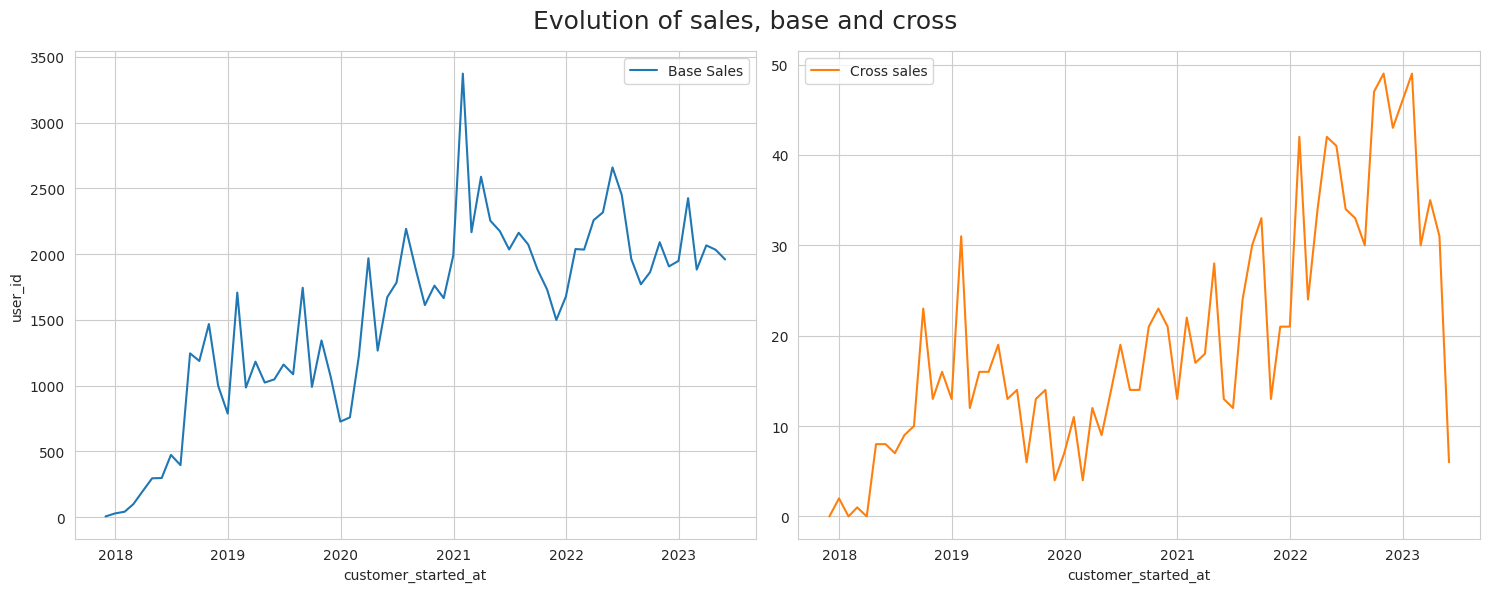

In [51]:
sns.set_style("whitegrid")
palette = sns.color_palette()
fig,axs = plt.subplots(1,2, figsize = (15,6))
sns.lineplot(plot_users["user_id"], ax = axs[0], color = palette[0], label="Base Sales")
sns.lineplot(plot_users["product_x"] + plot_users["product_y"], ax = axs[1], color = palette[1], label="Cross sales")
plt.suptitle("Evolution of sales, base and cross", fontsize=18)
plt.tight_layout()
plt.show()

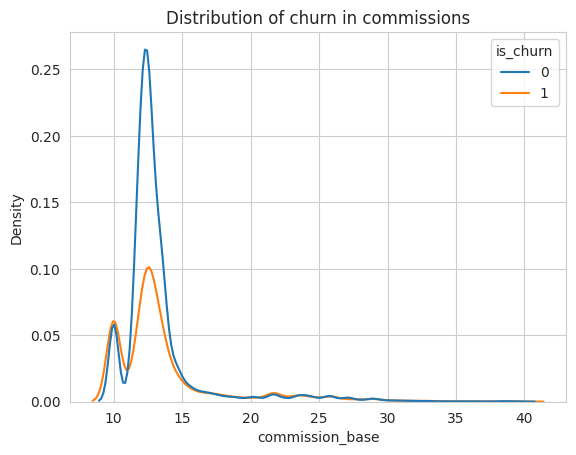

In [53]:
inf_lim, sup_lim = 0,40
col_to_plot = "commission_base"
dataplot = df.loc[(df[col_to_plot]<=sup_lim) & (df[col_to_plot]>=inf_lim)]
sns.kdeplot(data = dataplot, x= col_to_plot, hue=dataplot["is_churn"].astype(int))
plt.title("Distribution of churn in commissions")
plt.show()

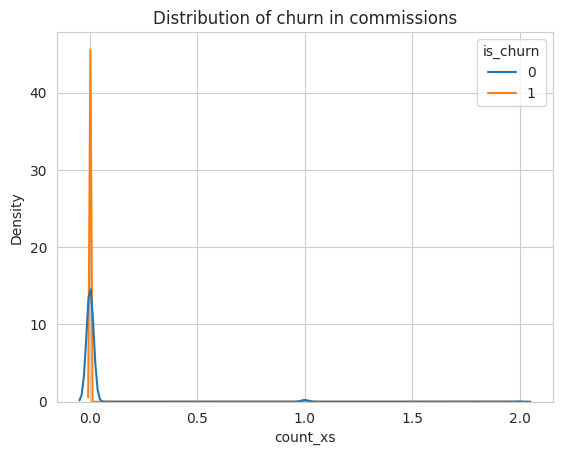

In [67]:
df.loc[:, "count_xs"] = df["product_x"].fillna(0) + df["product_y"].fillna(0)
inf_lim, sup_lim = 0,2
col_to_plot = "count_xs"
dataplot = df.loc[(df[col_to_plot]<=sup_lim) & (df[col_to_plot]>=inf_lim)]
sns.kdeplot(data = dataplot, x= col_to_plot, hue=dataplot["is_churn"].astype(int))
plt.title("Distribution of churn in commissions")
plt.show()

In [54]:
df = df.reset_index()

df

,index,customer_started_at,user_id,customer_churned_at,product,commission_base,channel,age_bucket,operating_system,commission_xs,product_x,product_y,is_churn,is_xs,days_to_churn
0,0,2020-12-01,37d76d441d,NaT,product_a,12.1775,channel_a,55+,iOS,NaN,NaN,NaN,False,0,NaN
1,1,2022-05-09,cdc1327d79,NaT,product_a,12.4575,channel_a,18-24,iOS,NaN,NaN,NaN,False,0,NaN
2,2,2021-11-20,fac8c03aa8,2023-01-01 00:00:00,product_c,21.6625,channel_a,35-39,Android,NaN,NaN,NaN,True,0,407.0
3,3,2020-05-21,b0c703a998,NaT,product_a,12.0475,channel_b,35-39,Android,NaN,NaN,NaN,False,0,NaN
4,4,2021-04-15,0276bcc756,NaT,product_c,15.7700,channel_b,35-39,Android,NaN,NaN,NaN,False,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102618,102618,2021-02-12,7df1a34a0d,NaT,product_a,12.6825,channel_a,45-49,iOS,NaN,NaN,NaN,False,0,NaN
102619,102619,2022-11-27,58ce7b5a49,NaT,product_b,13.6975,channel_a,45-49,iOS,NaN,NaN,NaN,False,0,NaN
102620,102620,2022-07-22,4744036910,NaT,product_a,12.1925,channel_a,45-49,iOS,NaN,NaN,NaN,False,0,NaN
102621,102621,2021-07-16,ca58e4734d,NaT,product_a,13.7525,channel_a,50-54,Android,NaN,NaN,NaN,False,0,NaN


In [36]:
df.loc[df["is_churn"], "days_to_churn"] = pd.to_datetime(df.loc[df["is_churn"],"customer_churned_at"]).subtract(df.loc[df["is_churn"] ,"customer_started_at"]).dt.days

<Axes: xlabel='days_to_churn', ylabel='Count'>

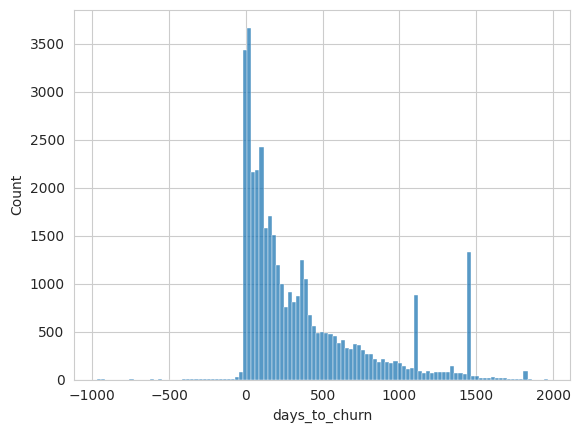

In [70]:
sns.histplot(df.loc[df["is_churn"], "days_to_churn"])

In [72]:
users_churn_negative = df.loc[df.loc[:, "days_to_churn"] <0]["user_id"].to_list()

In [73]:
base.loc[base["user_id"].isin(users_churn_negative)]

,user_id,customer_started_at,customer_churned_at,product,commission,channel,age_bucket,operating_system
24,2be74ed2d0,2020-11-01,2020-10-21,product_c,11.7700,channel_b,30-34,iOS
138,e2a48eefd4,2019-08-19,2019-08-18,product_a,12.5575,channel_a,30-34,Android
188,248b96ed87,2022-02-10,2022-02-09,product_b,17.7700,channel_b,30-34,iOS
235,fd42d75ac6,2020-05-03,2020-05-02,product_a,11.5225,channel_b,40-44,iOS
239,22fa81cbc6,2019-08-09,2019-08-08,product_a,12.5575,channel_a,25-29,Android
...,...,...,...,...,...,...,...,...
102289,e3d3ba4a43,2022-12-24,2022-12-23,product_a,13.4475,channel_b,25-29,iOS
102298,5a957c1a3f,2019-11-17,2019-11-16,product_a,12.5575,channel_a,18-24,iOS
102458,32907bbb05,2021-03-11,2021-03-10,product_c,15.7050,channel_b,35-39,iOS
102528,6d0f098e73,2022-09-29,2022-09-12,product_a,12.4575,channel_a,25-29,iOS
